Matching Networks Architecture implementation consists of the following 5 important parts:

- Embeddings Extractor, g.
- Full Context Embeddings, Bi-directional LSTM, f
- Cosine Similarity Distance Function, c
- Attention Model: Softmax(c)
- Loss Function: Cross Entropy Loss

In [3]:
!pip3 install tqdm
!pip3 install matplotlib
!pip3 install jetson-stats
!pip3 install torch-summary

    100% |################################| 71kB 482kB/s 
    100% |################################| 37.9MB 14kB/s 
    100% |################################| 61kB 3.5MB/s 
  Running setup.py bdist_wheel for matplotlib ... done
  Stored in directory: /root/.cache/pip/wheels/64/69/93/c4f0b9e8ca66368307cedef4f590c10e5f54216f777b8ba659
  Running setup.py bdist_wheel for kiwisolver ... done
  Stored in directory: /root/.cache/pip/wheels/69/47/4f/edfc446936a7fcde3e0ca13a51e0ff3ba1d4e12c1c74180254
Successfully built matplotlib kiwisolver
    100% |################################| 92kB 598kB/s 
  Running setup.py bdist_wheel for jetson-stats ... done
  Stored in directory: /root/.cache/pip/wheels/10/b8/2b/ef6fb5ee6a93798ea12e7fd2eb24f87526543f30428ab4a54c
Successfully built jetson-stats


In [2]:
#Import all necessary libraries

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.backends.cudnn as cudnn
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torchsummary import summary

import math

import numpy as np

import tqdm

import matplotlib.pyplot as plt 
%matplotlib inline

ModuleNotFoundError: No module named 'torchsummary'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [1]:

#Load omniglot dataset, tranformed in .npy format using helper script.
#In helper script, we are just loading data in size format: [total_number,character,28,28]. For more details, go through helper.py script.

x = np.load('data/data.npy') # Load Data
print (x.shape)
print (type(x))
x = np.reshape(x, newshape=(x.shape[0], x.shape[1], 28, 28, 1)) # expand dimension from (x.shape[0],x.shape[1],28,28)
np.random.shuffle(x) # shuffle dataset
x_train, x_val, x_test = x[:1200], x[1200:1411], x[1411:] # divide dataset in to train, val,ctest
batch_size = 16 # setting batch_size
n_classes = x.shape[0] # total number of classes
classes_per_set = 20 # Number of classes per set
samples_per_class = 1 # as we are choosing it to be one shot learning, so we have 1 sample
print (x_train.shape)
print (x_val.shape)
print( x_test.shape)

NameError: name 'np' is not defined

In [5]:
#Preprocess Images: Here we have use normalization method.

def processes_batch(data, mu, sigma):
    return (data - mu) / sigma

# Normalize Dataset
x_train = processes_batch(x_train, np.mean(x_train), np.std(x_train))
x_val = processes_batch(x_val, np.mean(x_val), np.std(x_val))
x_test = processes_batch(x_test, np.mean(x_test), np.std(x_test))

# Defining dictionary of dataset
datatset = {"train": x_train, "val": x_val, "test": x_test}

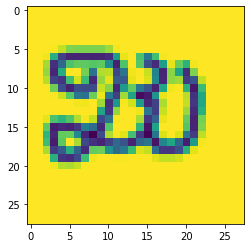

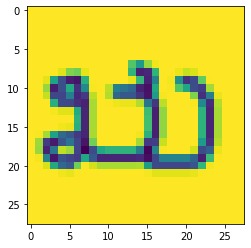

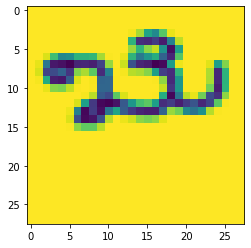

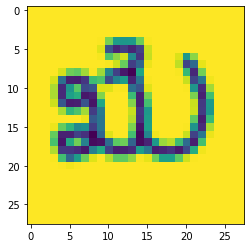

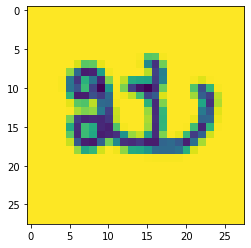

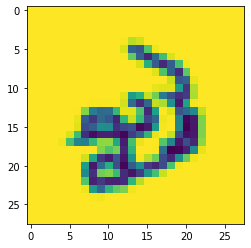

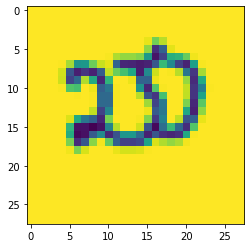

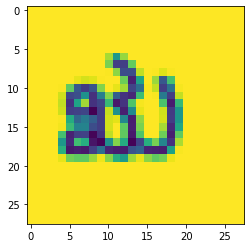

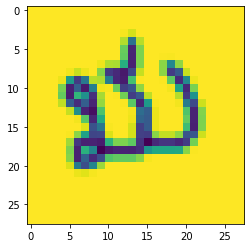

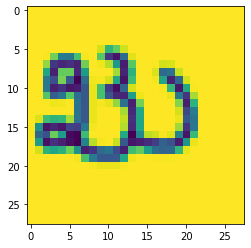

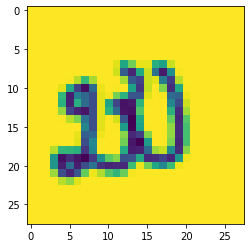

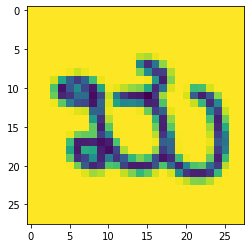

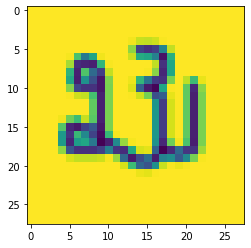

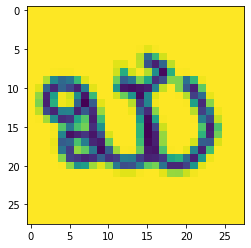

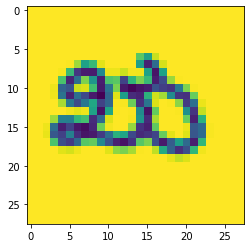

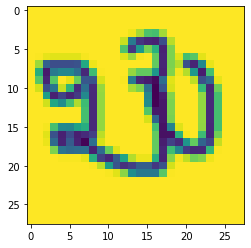

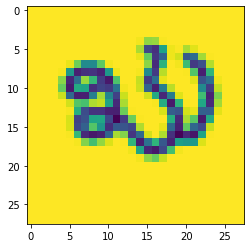

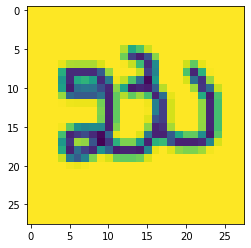

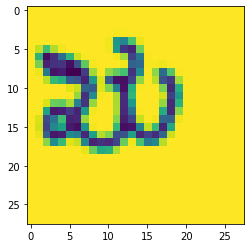

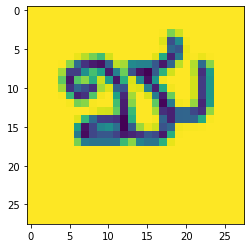

In [6]:
#Let's Visualize example of one character written by 20 people.

temp = x_train[0,:,:,:,:]  
for i in range(0,20):
    plt.figure()
    plt.imshow(temp[i,:,:,0])

In [7]:
#Step 3: Training Data Processing
#To Load Omniglot dataset, and prepare it for Matching Networks Architecture, we need to create:

#Label Set: Variable choose_label
#Support Set: support_set_x, support_set_y
#Batch from Suppport Set Examples
#Let's first create a batch which can give a support set, and target set.

def sample_batch(data):
        """
        Generates sample batch 
        :param : data - one of(train,test,val) our current dataset shape [total_classes,20,28,28,1]
        :return: [support_set_x,support_set_y,target_x,target_y] for Matching Networks
        """
        support_set_x = np.zeros((batch_size, classes_per_set, samples_per_class, data.shape[2],
                                  data.shape[3], data.shape[4]), np.float32)
        support_set_y = np.zeros((batch_size, classes_per_set, samples_per_class), np.int32)
        
        target_x = np.zeros((batch_size, data.shape[2], data.shape[3], data.shape[4]), np.float32)
        target_y = np.zeros((batch_size, 1), np.int32)
        for i in range(batch_size):
            choose_classes = np.random.choice(data.shape[0], size=classes_per_set, replace=False) # choosing random classes
            choose_label = np.random.choice(classes_per_set, size=1) # label set
            choose_samples = np.random.choice(data.shape[1], size=samples_per_class + 1, replace=False)
            x_temp = data[choose_classes] # choosing classes
            x_temp = x_temp[:, choose_samples] # choosing sample batch from classes chosen outputs 20X2X28X28X1
            y_temp = np.arange(classes_per_set) # will return [0,1,2,3,...,19]
            support_set_x[i] = x_temp[:, :-1]
            support_set_y[i] = np.expand_dims(y_temp[:], axis=1) # expand dimension
            target_x[i] = x_temp[choose_label, -1]
            target_y[i] = y_temp[choose_label]
        return support_set_x, support_set_y, target_x, target_y # returns support of [batch_size, 20 classes per set, 1 sample, 28, 28,1]
    
def get_batch(dataset_name):
        """
        gen batch while training
        :param dataset_name: The name of dataset(one of "train","val","test")
        :return: a batch images
        """
        support_set_x, support_set_y, target_x, target_y = sample_batch(datatset[dataset_name])
        support_set_x = support_set_x.reshape((support_set_x.shape[0], support_set_x.shape[1] * support_set_x.shape[2],
                                               support_set_x.shape[3], support_set_x.shape[4], support_set_x.shape[5]))
        support_set_y = support_set_y.reshape(support_set_y.shape[0], support_set_y.shape[1] * support_set_y.shape[2])
        return support_set_x, support_set_y, target_x, target_y

In [8]:
#Step 4: Create an Embeddings extractor

def convLayer(in_channels, out_channels, dropout_prob=0.0):
    """
    :param dataset_name: The name of dataset(one of "train","val","test")
    :return: a batch images
    """
    cnn_seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(True),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(dropout_prob)
    )
    return cnn_seq

class Embeddings_extractor(nn.Module):
    def __init__(self, layer_size=64, num_channels=1, dropout_prob=0.5, image_size=28):
        super(Embeddings_extractor, self).__init__()
        """
        Build a CNN to produce embeddings
        :param layer_size:64(default)
        :param num_channels:
        :param keep_prob:
        :param image_size:
        """
        self.layer1 = convLayer(num_channels, layer_size, dropout_prob)
        self.layer2 = convLayer(layer_size, layer_size, dropout_prob)
        self.layer3 = convLayer(layer_size, layer_size, dropout_prob)
        self.layer4 = convLayer(layer_size, layer_size, dropout_prob)

        finalSize = int(math.floor(image_size / (2 * 2 * 2 * 2)))
        self.outSize = finalSize * finalSize * layer_size

    def forward(self, image_input):
        """
        :param: Image
        :return: embeddings
        """
        x = self.layer1(image_input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size()[0], -1)
        return x

In [9]:
#step 5: Create an Attention model after classifier.

class AttentionalClassify(nn.Module):
    def __init__(self):
        super(AttentionalClassify, self).__init__()

    def forward(self, similarities, support_set_y):
        """
        Products pdfs over the support set classes for the target set image.
        :param similarities: A tensor with cosine similarites of size[batch_size,sequence_length]
        :param support_set_y:[batch_size,sequence_length,classes_num]
        :return: Softmax pdf shape[batch_size,classes_num]
        """
        softmax = nn.Softmax(dim=1)
        softmax_similarities = softmax(similarities)
        preds = softmax_similarities.unsqueeze(1).bmm(support_set_y).squeeze()
        return preds

In [10]:
#Step 6: Create a Distance Network, which will take output from Test Image, and training embeddings, to calculate the Distance.
#find cosine similarities between support set and input_test_image

class DistanceNetwork(nn.Module):
    """
    This model calculates the cosine distance between each of the support set embeddings and 
    the target image embeddings.
    """

    def __init__(self):
        super(DistanceNetwork, self).__init__()

    def forward(self, support_set, input_image):
        """
        forward pass
        :param support_set:the embeddings of the support set images.shape[sequence_length,batch_size,64]
        :param input_image: the embedding of the target image,shape[batch_size,64]
        :return:shape[batch_size,sequence_length]
        """
        eps = 1e-10
        similarities = []
        for support_image in support_set:
            sum_support = torch.sum(torch.pow(support_image, 2), 1)
            support_manitude = sum_support.clamp(eps, float("inf")).rsqrt()
            dot_product = input_image.unsqueeze(1).bmm(support_image.unsqueeze(2)).squeeze()
            cosine_similarity = dot_product * support_manitude
            similarities.append(cosine_similarity)
        similarities = torch.stack(similarities)
        return similarities.t()

In [11]:
#Step 7: Create a Bi-directional LSTM, which is taking input and output from Test-image, and put them in same embeddings space.
#If we wish to use full-context embeddings, Matching Networks introduced Bi-directional LSTM for it.

class BidirectionalLSTM(nn.Module):
    def __init__(self, layer_size, batch_size, vector_dim):
        super(BidirectionalLSTM, self).__init__()
        """
        Initial a muti-layer Bidirectional LSTM
        :param layer_size: a list of each layer'size
        :param batch_size: 
        :param vector_dim: 
        """
        self.batch_size = batch_size
        self.hidden_size = layer_size[0]
        self.vector_dim = vector_dim
        self.num_layer = len(layer_size)
        self.lstm = nn.LSTM(input_size=self.vector_dim, num_layers=self.num_layer, hidden_size=self.hidden_size,
                            bidirectional=True)
        self.hidden = (Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size),requires_grad=False),
                Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size),requires_grad=False))

    def repackage_hidden(self,h):
        """Wraps hidden states in new Variables, 
        to detach them from their history."""
        if type(h) == torch.Tensor:
            return Variable(h.data).to(device)
        else:
            return tuple(self.repackage_hidden(v) for v in h)
        
    def forward(self, inputs):
        self.hidden = self.repackage_hidden(self.hidden)
        output, self.hidden = self.lstm(inputs, self.hidden)
        return output

In [12]:
#Let's club all small modules we made, and create a matching network.¶

class MatchingNetwork(nn.Module):
    def __init__(self, keep_prob, batch_size=32, num_channels=1, learning_rate=1e-3, fce=False, num_classes_per_set=20, \
                 num_samples_per_class=1, image_size=28):
        """
        Matching Network
        :param keep_prob: dropout rate
        :param batch_size:
        :param num_channels:
        :param learning_rate:
        :param fce: Flag indicating whether to use full context embeddings(i.e. apply an LSTM on the CNN embeddings)
        :param num_classes_per_set:
        :param num_samples_per_class:
        :param image_size:
        """
        super(MatchingNetwork, self).__init__()
        self.batch_size = batch_size
        self.keep_prob = keep_prob
        self.num_channels = num_channels
        self.learning_rate = learning_rate
        self.num_classes_per_set = num_classes_per_set
        self.num_samples_per_class = num_samples_per_class
        self.image_size = image_size
        # Let's set all peices of Matching Networks Architecture
        self.g = Embeddings_extractor(layer_size=64, num_channels=num_channels, dropout_prob=keep_prob, image_size=image_size)
        self.f = fce # if we are considering full-context embeddings
        self.c = DistanceNetwork() # cosine distance among embeddings
        self.a = AttentionalClassify() # softmax of cosine distance of embeddings
        if self.f:
            self.lstm = BidirectionalLSTM(layer_size=[32], batch_size=self.batch_size, vector_dim=self.g.outSize)

    def forward(self, support_set_images, support_set_y_one_hot, target_image, target_y):
        """
        Main process of the network
        :param support_set_images: shape[batch_size,sequence_length,num_channels,image_size,image_size]
        :param support_set_y_one_hot: shape[batch_size,sequence_length,num_classes_per_set]
        :param target_image: shape[batch_size,num_channels,image_size,image_size]
        :param target_y:
        :return:
        """
        # produce embeddings for support set images
        encoded_images = []
        for i in np.arange(support_set_images.size(1)):
            gen_encode = self.g(support_set_images[:, i, :, :])
            encoded_images.append(gen_encode)
            
        # produce embeddings for target images
        gen_encode = self.g(target_image)
        encoded_images.append(gen_encode)
        output = torch.stack(encoded_images,dim=0)
        
        # if we are considering full-context embeddings
        if self.f:
            output = self.lstm(output)
            
        # get similarities between support set embeddings and target
        similarites = self.c(support_set=output[:-1], input_image=output[-1])
        
        # produce predictions for target probabilities
        preds = self.a(similarites, support_set_y=support_set_y_one_hot)
        
        # calculate the accuracy
        values, indices = preds.max(1)
        accuracy = torch.mean((indices.squeeze() == target_y).float())
        crossentropy_loss = F.cross_entropy(preds, target_y.long())

        return accuracy, crossentropy_loss

In [13]:
#Step 9: Create a Dataset Loader.
#For our case, as we are using Omniglot Dataset,it will create a Omnligloat builder which calls Matching Network, and run its epochs for training, testing, and validation purpose.

def run_epoch(total_train_batches, name='train'):
    """
    Run the training epoch
    :param total_train_batches: Number of batches to train on
    :return:
    """
    total_c_loss = 0.0
    total_accuracy = 0.0
    for i in range(int(total_train_batches)):
            x_support_set, y_support_set, x_target, y_target = get_batch(name)
            x_support_set = Variable(torch.from_numpy(x_support_set)).float()
            y_support_set = Variable(torch.from_numpy(y_support_set), requires_grad=False).long()
            x_target = Variable(torch.from_numpy(x_target)).float()
            y_target = Variable(torch.from_numpy(y_target), requires_grad=False).squeeze().long()

            # convert to one hot encoding
            y_support_set = y_support_set.unsqueeze(2)
            sequence_length = y_support_set.size()[1]
            batch_size = y_support_set.size()[0]
            y_support_set_one_hot = Variable(torch.zeros(batch_size, sequence_length, classes_per_set).scatter_(2,y_support_set.data,1), requires_grad=False)

            # reshape channels and change order
            size = x_support_set.size()
            x_support_set = x_support_set.permute(0, 1, 4, 2, 3)
            x_target = x_target.permute(0, 3, 1, 2)

            x_support_set, y_support_set_one_hot, x_target, y_target = x_support_set.to(device), y_support_set_one_hot.to(device), x_target.to(device), y_target.to(device)
            
            acc, c_loss = matchNet(x_support_set, y_support_set_one_hot, x_target, y_target)

            # optimize process
            optimizer.zero_grad()
            c_loss.backward()
            optimizer.step()

            iter_out = "tr_loss: {}, tr_accuracy: {}".format(c_loss, acc)
            total_c_loss += c_loss
            total_accuracy += acc

    total_c_loss = total_c_loss / total_train_batches
    total_accuracy = total_accuracy / total_train_batches
    return total_c_loss, total_accuracy

In [14]:

batch_size=20
num_channels=1
lr=1e-3
image_size=28
classes_per_set=20
samples_per_class=1
keep_prob=0.0
fce=True
optim="adam"
wd=0
matchNet = MatchingNetwork(keep_prob, batch_size, num_channels, lr, fce, classes_per_set,
                                samples_per_class, image_size)
matchNet.to(device)

total_iter = 0
total_train_iter = 0
optimizer = torch.optim.Adam(matchNet.parameters(), lr=lr, weight_decay=wd)
scheduler = ReduceLROnPlateau(optimizer, 'min',verbose=True)

# Training setup
total_epochs = 100
total_train_batches = 10
total_val_batches = 5
total_test_batches = 5

In [15]:
summary(matchNet)


Layer (type:depth-idx)                   Param #
├─Embeddings_extractor: 1-1              --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  640
|    |    └─ReLU: 3-2                    --
|    |    └─BatchNorm2d: 3-3             128
|    |    └─MaxPool2d: 3-4               --
|    |    └─Dropout: 3-5                 --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-6                  36,928
|    |    └─ReLU: 3-7                    --
|    |    └─BatchNorm2d: 3-8             128
|    |    └─MaxPool2d: 3-9               --
|    |    └─Dropout: 3-10                --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-11                 36,928
|    |    └─ReLU: 3-12                   --
|    |    └─BatchNorm2d: 3-13            128
|    |    └─MaxPool2d: 3-14              --
|    |    └─Dropout: 3-15                --
|    └─Sequential: 2-4                   --
|    |    └─Conv2d: 3-16                 36,928
|    |    └

Layer (type:depth-idx)                   Param #
├─Embeddings_extractor: 1-1              --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  640
|    |    └─ReLU: 3-2                    --
|    |    └─BatchNorm2d: 3-3             128
|    |    └─MaxPool2d: 3-4               --
|    |    └─Dropout: 3-5                 --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-6                  36,928
|    |    └─ReLU: 3-7                    --
|    |    └─BatchNorm2d: 3-8             128
|    |    └─MaxPool2d: 3-9               --
|    |    └─Dropout: 3-10                --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-11                 36,928
|    |    └─ReLU: 3-12                   --
|    |    └─BatchNorm2d: 3-13            128
|    |    └─MaxPool2d: 3-14              --
|    |    └─Dropout: 3-15                --
|    └─Sequential: 2-4                   --
|    |    └─Conv2d: 3-16                 36,928
|    |    └

In [16]:
train_loss,train_accuracy=[],[]
val_loss,val_accuracy=[],[]
test_loss,test_accuracy=[],[]


for e in range(total_epochs):
    ############################### Training Step ##########################################
    total_c_loss, total_accuracy = run_epoch(total_train_batches,'train')
    train_loss.append(total_c_loss)
    train_accuracy.append(total_accuracy)
    
    ################################# Validation Step #######################################
    total_val_c_loss, total_val_accuracy = run_epoch(total_val_batches, 'val')
    val_loss.append(total_val_c_loss)
    val_accuracy.append(total_val_accuracy)
    print("Epoch {}: train_loss:{:.2f} train_accuracy:{:.2f} valid_loss:{:.2f} valid_accuracy:{:.2f}".
          format(e, total_c_loss, total_accuracy, total_val_c_loss, total_val_accuracy))

Epoch 0: train_loss:2.98 train_accuracy:0.17 valid_loss:2.97 valid_accuracy:0.21
Epoch 1: train_loss:2.95 train_accuracy:0.28 valid_loss:2.94 valid_accuracy:0.28
Epoch 2: train_loss:2.92 train_accuracy:0.33 valid_loss:2.91 valid_accuracy:0.38
Epoch 3: train_loss:2.89 train_accuracy:0.43 valid_loss:2.88 valid_accuracy:0.41
Epoch 4: train_loss:2.88 train_accuracy:0.39 valid_loss:2.85 valid_accuracy:0.44
Epoch 5: train_loss:2.86 train_accuracy:0.43 valid_loss:2.85 valid_accuracy:0.45
Epoch 6: train_loss:2.84 train_accuracy:0.44 valid_loss:2.84 valid_accuracy:0.42
Epoch 7: train_loss:2.83 train_accuracy:0.46 valid_loss:2.79 valid_accuracy:0.56
Epoch 8: train_loss:2.79 train_accuracy:0.57 valid_loss:2.84 valid_accuracy:0.47
Epoch 9: train_loss:2.77 train_accuracy:0.62 valid_loss:2.79 valid_accuracy:0.48
Epoch 10: train_loss:2.77 train_accuracy:0.54 valid_loss:2.76 valid_accuracy:0.56
Epoch 11: train_loss:2.74 train_accuracy:0.59 valid_loss:2.79 valid_accuracy:0.44
Epoch 12: train_loss:2.72 

In [17]:
#Now Let's obtain our test accuracy by running the following code block:

total_test_c_loss, total_test_accuracy = run_epoch(total_test_batches,'test')
print("test_accuracy:{}%".format(total_test_accuracy*100))

test_accuracy:82.00000762939453%


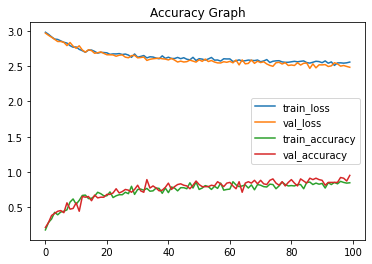

In [18]:
#Let's visualize our results

def plot_loss(train,val,name1="train_loss",name2="val_loss",title=""):
    plt.title(title)
    plt.plot(train, label=name1)
    plt.plot(val, label=name2)
    plt.legend()

plot_loss(train_loss,val_loss,"train_loss","val_loss","Loss Graph")
plot_loss(train_accuracy,val_accuracy,"train_accuracy","val_accuracy","Accuracy Graph")
